## EDSR

This notebook is an implementation of a EDSR notebook.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Add, Activation, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [3]:
import cv2
import numpy as np

In [4]:
import matplotlib.pyplot as plt

### EDSR Dataset Preprocessing

In [5]:
ds_train = tfds.load('div2k/bicubic_x2', split='train')

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X2.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x2/incomplete.5N4FFD_2.0.0/div2k-train.tfrecord*...:   0%|  …

Generating validation examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x2/incomplete.5N4FFD_2.0.0/div2k-validation.tfrecord*...:   …

Dataset div2k downloaded and prepared to /root/tensorflow_datasets/div2k/bicubic_x2/2.0.0. Subsequent calls will reuse this data.


In [6]:
def train_low(ds_train, size, scale):
    data = []
    for example in ds_train:
        hr_image = example['hr'].numpy()  # extract high-resolution image

        # convert from TensorFlow tensor to numpy array and from YCbCr to BGR
        hr_image_bgr = cv2.cvtColor(hr_image, cv2.COLOR_YCrCb2BGR)

        # downsample and upsample using bicubic interpolation
        img = cv2.resize(hr_image_bgr, (size, size), cv2.INTER_CUBIC)
        img = cv2.resize(img, (size * scale, size * scale), cv2.INTER_CUBIC)

        # convert back to YCrCb and extract luma (Y) channel
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        img = img[:, :, 0].astype(float) / 255

        data.append(img)

    data = np.array(data)

    return data

In [7]:
y_train_low = train_low(ds_train, 128, 2)

In [8]:
def train_high(ds_train, size):
    data = []
    for example in ds_train:
        hr_image = example['hr'].numpy()  # extract high-resolution image

        # convert from TensorFlow tensor to numpy array and from YCbCr to BGR
        hr_image_bgr = cv2.cvtColor(hr_image, cv2.COLOR_YCrCb2BGR)

        img = cv2.resize(hr_image_bgr, (size, size))

        # convert back to YCrCb and extract luma (Y) channel
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        img = img[:, :, 0].astype(float) / 255

        data.append(img)

    data = np.array(data)

    return data

In [9]:
X_train_high = train_high(ds_train, 512)

### EDSR Architecture

In [10]:
def edsr(scale, num_filters=64, num_res_blocks=16, res_scale=0.1):
    input = Input(shape=(None, None, 1))

    # pre-residual block
    x = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer='he_normal')(input)

    # residual blocks
    res = x
    for i in range(num_res_blocks):
        x = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
        x = Activation('relu')(x)
        x = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
        x = Add()([res, x * res_scale])
        res = x

    # post-residual block
    x = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = Add()([x, res])

    # upscaling
    x = Conv2D(num_filters * (scale ** 2), (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = tf.nn.depth_to_space(x, scale)

    # final output layer to ensure single channel output
    output = Conv2D(1, (3, 3), padding='same', kernel_initializer='he_normal')(x)

    # model
    model = Model(inputs=input, outputs=output)

    return model

In [11]:
edsr = edsr(scale=2)
edsr.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 1)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 64)       640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, None, None, 64)       36928     ['conv2d[0][0]']              
                                                                                                  
 activation (Activation)     (None, None, None, 64)       0         ['conv2d_1[0][0]']            
                                                                                              

### Compile the model

In [12]:
edsr.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

### Observe the dataset

Text(0.5, 1.0, 'high resolution ')

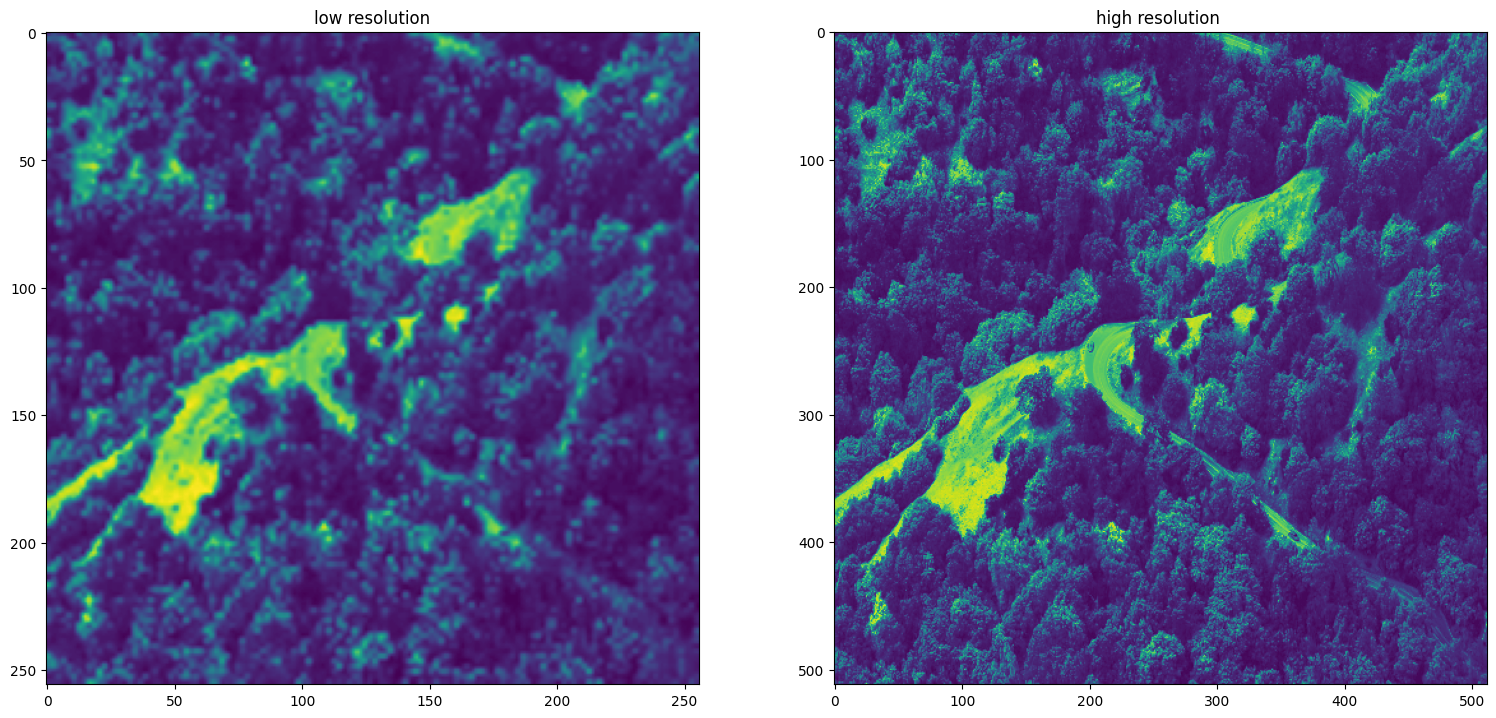

In [13]:
plt.figure(figsize = (100, 100))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(y_train_low[10])
plt.title("low resolution")
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(X_train_high[10])
plt.title("high resolution ")

### Change the data shape

In [14]:
low= np.zeros((y_train_low.shape[0], y_train_low.shape[1], y_train_low.shape[2], 1), dtype=float)
low[:, :, :, 0]=y_train_low[:, :, :].astype(float)
low.shape

(800, 256, 256, 1)

In [15]:
high= np.zeros((X_train_high.shape[0], X_train_high.shape[1], X_train_high.shape[2], 1), dtype=float)
high[:, :, :, 0]=X_train_high[:, :, :].astype(float)
high.shape

(800, 512, 512, 1)

### Define callback

In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

### Train the model

In [17]:
history = edsr.fit(low, high, batch_size=10, validation_split=0.2, shuffle=True, epochs=20, callbacks=[callback])

Epoch 1/20
64/64 [==============================] - 128s 2s/step - loss: 3.4580 - mean_absolute_error: 0.6034 - val_loss: 0.0080 - val_mean_absolute_error: 0.0574
Epoch 2/20
64/64 [==============================] - 102s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0468 - val_loss: 0.0050 - val_mean_absolute_error: 0.0409
Epoch 3/20
64/64 [==============================] - 102s 2s/step - loss: 0.0050 - mean_absolute_error: 0.0417 - val_loss: 0.0047 - val_mean_absolute_error: 0.0393
Epoch 4/20
64/64 [==============================] - 102s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0396 - val_loss: 0.0045 - val_mean_absolute_error: 0.0374
Epoch 5/20
64/64 [==============================] - 102s 2s/step - loss: 0.0047 - mean_absolute_error: 0.0389 - val_loss: 0.0045 - val_mean_absolute_error: 0.0380
Epoch 6/20
64/64 [==============================] - 105s 2s/step - loss: 0.0047 - mean_absolute_error: 0.0392 - val_loss: 0.0044 - val_mean_absolute_error: 0.0368
Epoch 7/20
64/64 [====

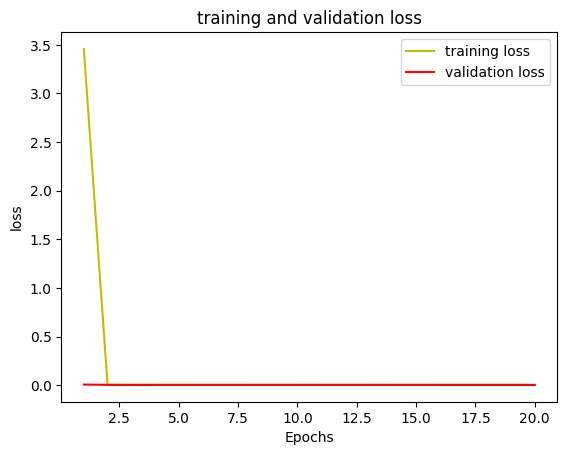

In [18]:
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,'y',label="training loss")
plt.plot(epochs,val_loss,'r',label="validation loss")
plt.title("training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [25]:
edsr.save('edsr_model.keras')

### Testing EDSR

In [20]:
import time

In [21]:
edsr_model = tf.keras.models.load_model("edsr_model.keras")

In [22]:
edsr_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 1)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 64)       640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, None, None, 64)       36928     ['conv2d[0][0]']              
                                                                                                  
 activation (Activation)     (None, None, None, 64)       0         ['conv2d_1[0][0]']            
                                                                                              

In [23]:
upscale_factor = 2
fullimg = cv2.imread("halfwoman.jpg")  # input shape

print("Start image shape:", fullimg.shape)
width = fullimg.shape[1]
height = fullimg.shape[0]
img = fullimg

floatimg = img.astype(np.float32) / 255.0
imgYCbCr = cv2.cvtColor(floatimg, cv2.COLOR_BGR2YCrCb)
imgY = imgYCbCr[:, :, 0]
imgY_upscaled = cv2.resize(imgY, (width * upscale_factor, height * upscale_factor), interpolation=cv2.INTER_CUBIC)
imgY_upscaled = np.expand_dims(imgY_upscaled, axis=2)

print("Upscaled imgY shape:", imgY_upscaled.shape)

t0 = time.time()
LR_input_ = imgY_upscaled.reshape(1, imgY_upscaled.shape[0], imgY_upscaled.shape[1], 1)
t1 = time.time() - t0
print("Time elapsed: ", t1)

Y = edsr_model.predict([LR_input_])[0]
print("Predicted Y shape:", Y.shape)

Y = Y.clip(0, 1)

# upscale Cr and Cb channels using the same dimensions as Y
Cr = np.expand_dims(cv2.resize(imgYCbCr[:, :, 1], (Y.shape[1], Y.shape[0]), interpolation=cv2.INTER_CUBIC), axis=2)
Cb = np.expand_dims(cv2.resize(imgYCbCr[:, :, 2], (Y.shape[1], Y.shape[0]), interpolation=cv2.INTER_CUBIC), axis=2)

print("Cr shape:", Cr.shape)
print("Cb shape:", Cb.shape)

# concatenate Y, Cr, and Cb channels
HR_image_YCrCb = np.concatenate((Y, Cr, Cb), axis=2)

print("HR_image_YCrCb shape:", HR_image_YCrCb.shape)

# convert YCrCb to BGR
HR_image = cv2.cvtColor(HR_image_YCrCb, cv2.COLOR_YCrCb2BGR)

# scale to 0-255 and convert to uint8
HR_image = (HR_image * 255.0).clip(min=0, max=255).astype(np.uint8)
print("HR image shape:", HR_image.shape)

cv2.imwrite("edsr_quarwoman2.png", HR_image)

Start image shape: (172, 114, 3)
Upscaled imgY shape: (344, 228, 1)
Time elapsed:  0.00012946128845214844
1/1 [==============================] - 2s 2s/step
Predicted Y shape: (688, 456, 1)
Cr shape: (688, 456, 1)
Cb shape: (688, 456, 1)
HR_image_YCrCb shape: (688, 456, 3)
HR image shape: (688, 456, 3)


True

Text(0.5, 1.0, 'Model')

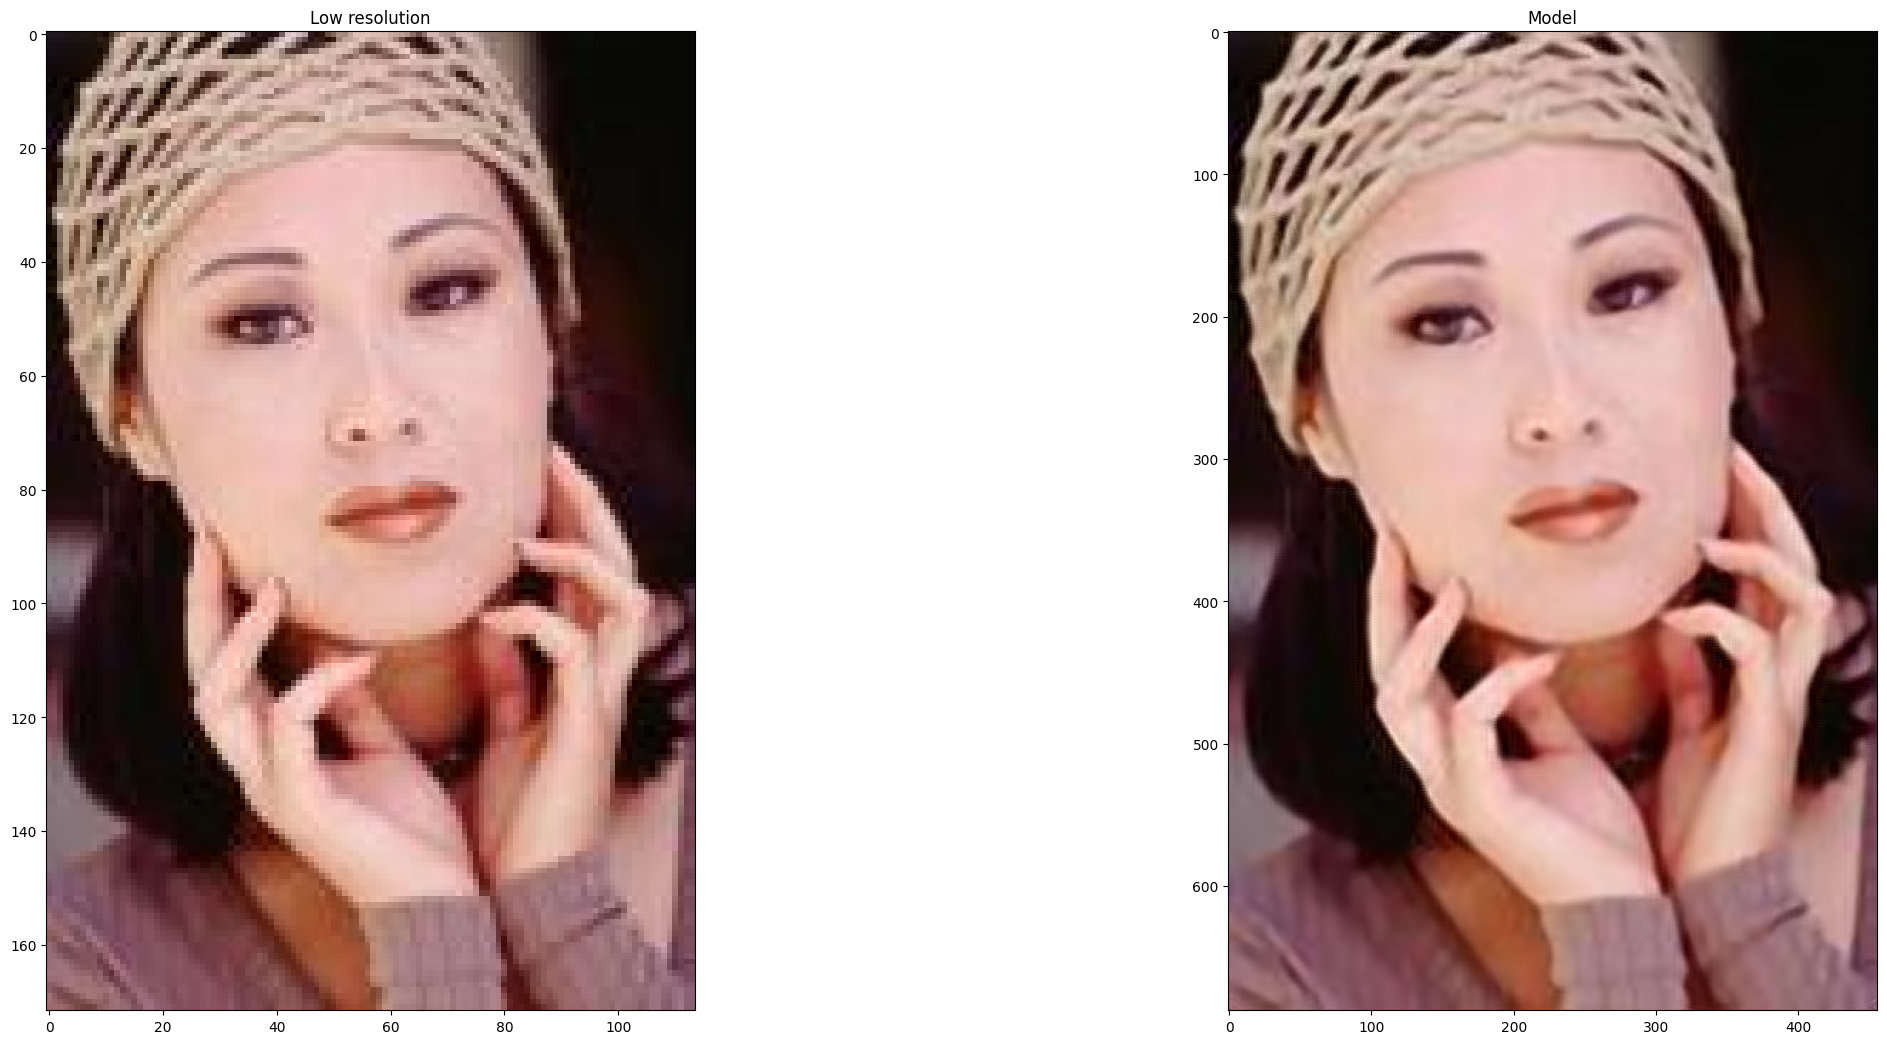

In [24]:
plt.figure(figsize = (150, 150))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(cv2.cvtColor(fullimg, cv2.COLOR_BGR2RGB))
plt.title("Low resolution")
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(cv2.cvtColor(HR_image, cv2.COLOR_BGR2RGB))
plt.title("Model")